In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/bird_CUB_200_2011 (2).zip' /content
!unzip '/content/bird_CUB_200_2011 (2).zip'

Streaming output truncated to the last 5000 lines.
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0064_30328.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0065_30357.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0067_30397.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0070_30147.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0076_30117.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0077_30296.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0080_30457.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0081_30380.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0082_30132.jpg  
  inflating: bird_CUB_200_2011/train/039.Least_Flycatcher/Least_Flycatcher_0092_30154.jpg  
  inflating: bird_CUB_200_201

In [3]:
#use torch=1.10.1 and torchvision=0.11.2
!pip install -U torch torchvision
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.6 MB/s eta 0:00:00


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import time
from tqdm import tqdm
import os

In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split

In [6]:
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [7]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
np.random.seed(42)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
import numpy as np
from torchvision import models

In [10]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [11]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#             transforms.RandomErasing(p=0.25, value='random')
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.90)
        valid_data_len = int((len(all_data) - train_data_len))
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data_len
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.90)
        valid_data_len = int((len(all_data) - train_data_len))
        test_data = datasets.ImageFolder("/content/bird_CUB_200_2011/test", transform=transform)
        test_data_len = int(len(test_data))
        train_data, val_data = random_split(all_data, [train_data_len, valid_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return (val_loader, test_loader, valid_data_len, test_data_len)

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
dataset_path = "/content/bird_CUB_200_2011/train"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 64, train=False)
classes = get_classes(dataset_path)

In [14]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [15]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

169
10
91


In [16]:
print(train_data_len, test_data_len, valid_data_len)

5394 5794 600


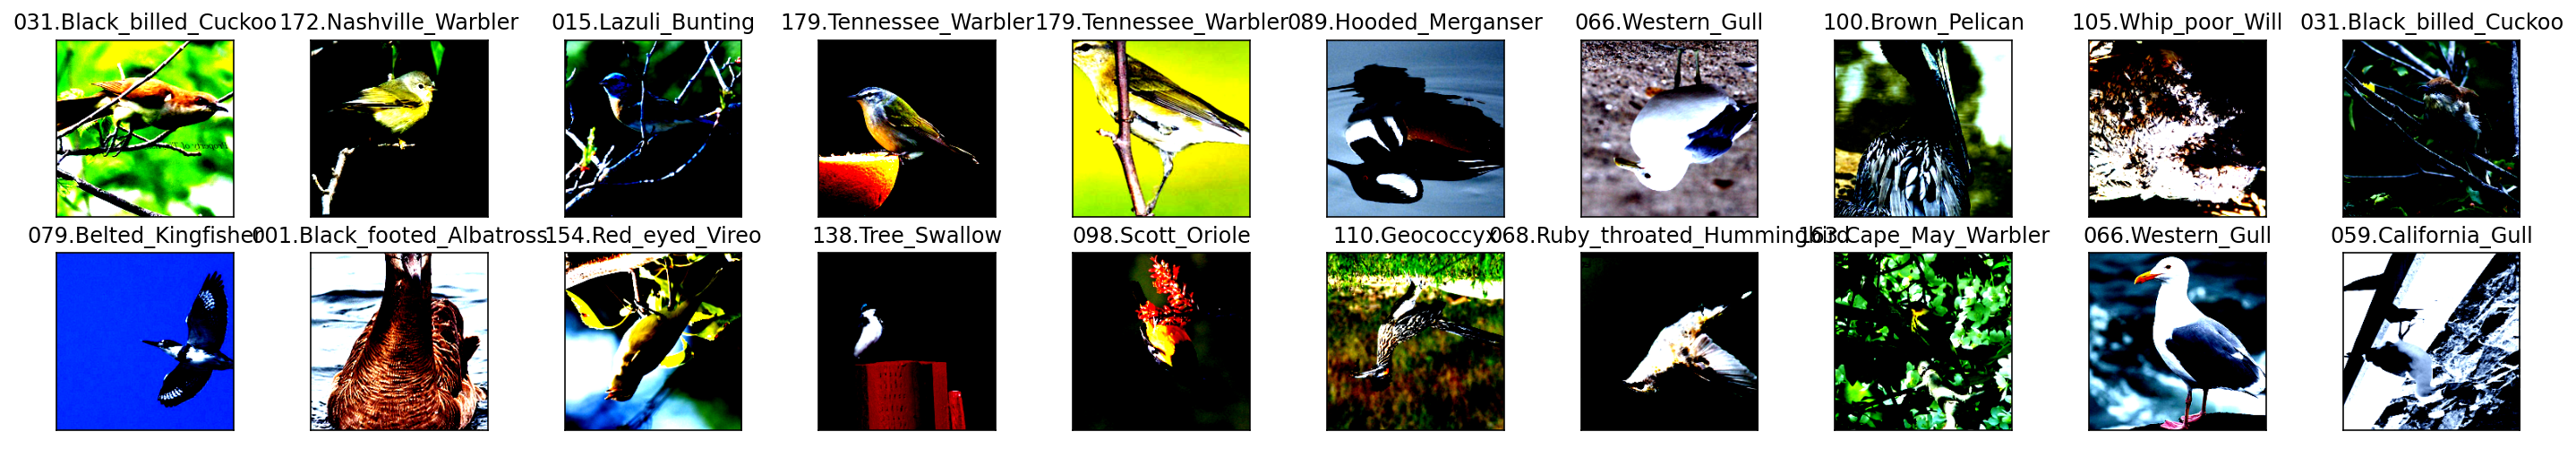

In [17]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
# model = torch.hub.load('facebookresearch/deit:main', 'resmlp_12', pretrained=True)
# Running model for Resnet101 since this was the best model
# To run models Resnet50 and Efficientnet_b0, uncomment the below models for the same
torch.backends.cudnn.benchmark = True
model = torchvision.models.resnet101(pretrained=True)
# model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.efficientnet_b0(pretrained=True)     
model

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
# for param in model.parameters():
#    param.requires_grad = False

# n_inputs = model.classifier[1].in_features
# print(n_inputs)

# model.classifier = nn.Sequential(
#    nn.Linear(n_inputs,2048),
#    nn.SiLU(),
#    nn.Dropout(0.1),
#    nn.Linear(2048, len(classes))
# )

model.fc = nn.Linear(model.fc.in_features, 200)
model = model.to(device)
# model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
print(f"Trainable Params: {count_parameters(model)}")

Trainable Params: 42909960


In [23]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [24]:
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [25]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [26]:
from torch.autograd import Variable

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) 
                    #loss.requires_grad = True      
                    #loss = Variable(loss, requires_grad = True)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model_ft = train_model(model, criterion, optimizer, step_scheduler,
                       num_epochs=18)

Epoch 0/17
----------


100%|██████████| 169/169 [01:48<00:00,  1.56it/s]


train Loss: 4.4421 Acc: 0.1902


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


val Loss: 3.3651 Acc: 0.4550

Epoch 1/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 3.1065 Acc: 0.5174


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


val Loss: 2.6470 Acc: 0.6817

Epoch 2/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.72it/s]


train Loss: 2.5499 Acc: 0.7086


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


val Loss: 2.3035 Acc: 0.7867

Epoch 3/17
----------


100%|██████████| 169/169 [01:40<00:00,  1.68it/s]


train Loss: 2.2676 Acc: 0.8118


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


val Loss: 2.1547 Acc: 0.8467

Epoch 4/17
----------


100%|██████████| 169/169 [01:38<00:00,  1.71it/s]


train Loss: 2.0910 Acc: 0.8721


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


val Loss: 2.0227 Acc: 0.8950

Epoch 5/17
----------


100%|██████████| 169/169 [01:38<00:00,  1.71it/s]


train Loss: 1.9623 Acc: 0.9195


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


val Loss: 1.9397 Acc: 0.9317

Epoch 6/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 1.9030 Acc: 0.9414


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


val Loss: 1.9446 Acc: 0.9333

Epoch 7/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 1.8430 Acc: 0.9566


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


val Loss: 1.8655 Acc: 0.9533

Epoch 8/17
----------


100%|██████████| 169/169 [01:38<00:00,  1.72it/s]


train Loss: 1.7965 Acc: 0.9761


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


val Loss: 1.8521 Acc: 0.9483

Epoch 9/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 1.7738 Acc: 0.9750


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


val Loss: 1.8565 Acc: 0.9567

Epoch 10/17
----------


100%|██████████| 169/169 [01:38<00:00,  1.72it/s]


train Loss: 1.7159 Acc: 0.9917


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


val Loss: 1.7858 Acc: 0.9683

Epoch 11/17
----------


100%|██████████| 169/169 [01:42<00:00,  1.65it/s]


train Loss: 1.6851 Acc: 0.9948


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


val Loss: 1.7653 Acc: 0.9683

Epoch 12/17
----------


100%|██████████| 169/169 [01:40<00:00,  1.68it/s]


train Loss: 1.6725 Acc: 0.9983


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


val Loss: 1.7560 Acc: 0.9700

Epoch 13/17
----------


100%|██████████| 169/169 [01:40<00:00,  1.68it/s]


train Loss: 1.6614 Acc: 0.9985


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


val Loss: 1.7448 Acc: 0.9717

Epoch 14/17
----------


100%|██████████| 169/169 [01:38<00:00,  1.71it/s]


train Loss: 1.6527 Acc: 0.9993


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


val Loss: 1.7356 Acc: 0.9733

Epoch 15/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 1.6480 Acc: 0.9993


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


val Loss: 1.7355 Acc: 0.9717

Epoch 16/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 1.6438 Acc: 0.9996


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


val Loss: 1.7366 Acc: 0.9717

Epoch 17/17
----------


100%|██████████| 169/169 [01:37<00:00,  1.73it/s]


train Loss: 1.6385 Acc: 0.9998


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

val Loss: 1.7296 Acc: 0.9717

Training complete in 31m 41s
Best val Acc: 0.973333


In [28]:
torch.cuda.empty_cache()

  1%|          | 1/91 [00:02<03:00,  2.01s/it]

tensor(2.0971, device='cuda:0')


  2%|▏         | 2/91 [00:02<01:34,  1.07s/it]

tensor(2.4192, device='cuda:0')


  3%|▎         | 3/91 [00:02<01:04,  1.36it/s]

tensor(2.3072, device='cuda:0')


  4%|▍         | 4/91 [00:03<00:51,  1.70it/s]

tensor(2.4156, device='cuda:0')


  5%|▌         | 5/91 [00:03<00:48,  1.76it/s]

tensor(2.3225, device='cuda:0')


  7%|▋         | 6/91 [00:04<00:44,  1.92it/s]

tensor(2.3479, device='cuda:0')


  8%|▊         | 7/91 [00:04<00:40,  2.07it/s]

tensor(2.0822, device='cuda:0')


  9%|▉         | 8/91 [00:04<00:38,  2.13it/s]

tensor(2.3202, device='cuda:0')


 10%|▉         | 9/91 [00:06<01:00,  1.36it/s]

tensor(2.2381, device='cuda:0')


 11%|█         | 10/91 [00:06<00:52,  1.54it/s]

tensor(2.1643, device='cuda:0')


 12%|█▏        | 11/91 [00:07<00:45,  1.75it/s]

tensor(2.3803, device='cuda:0')


 13%|█▎        | 12/91 [00:07<00:41,  1.92it/s]

tensor(2.2338, device='cuda:0')


 14%|█▍        | 13/91 [00:08<01:02,  1.24it/s]

tensor(2.3339, device='cuda:0')


 15%|█▌        | 14/91 [00:09<00:54,  1.41it/s]

tensor(2.1008, device='cuda:0')


 16%|█▋        | 15/91 [00:09<00:46,  1.63it/s]

tensor(2.2216, device='cuda:0')


 18%|█▊        | 16/91 [00:10<00:40,  1.87it/s]

tensor(2.2162, device='cuda:0')


 19%|█▊        | 17/91 [00:10<00:43,  1.71it/s]

tensor(1.9775, device='cuda:0')


 20%|█▉        | 18/91 [00:11<00:39,  1.85it/s]

tensor(2.3703, device='cuda:0')


 21%|██        | 19/91 [00:11<00:35,  2.03it/s]

tensor(2.2702, device='cuda:0')


 22%|██▏       | 20/91 [00:12<00:32,  2.19it/s]

tensor(2.1898, device='cuda:0')


 23%|██▎       | 21/91 [00:12<00:34,  2.03it/s]

tensor(2.6188, device='cuda:0')


 24%|██▍       | 22/91 [00:13<00:31,  2.17it/s]

tensor(2.2698, device='cuda:0')


 25%|██▌       | 23/91 [00:13<00:30,  2.25it/s]

tensor(2.2778, device='cuda:0')


 26%|██▋       | 24/91 [00:13<00:28,  2.38it/s]

tensor(2.1377, device='cuda:0')


 27%|██▋       | 25/91 [00:14<00:28,  2.34it/s]

tensor(2.2511, device='cuda:0')


 29%|██▊       | 26/91 [00:14<00:27,  2.40it/s]

tensor(2.2041, device='cuda:0')


 30%|██▉       | 27/91 [00:15<00:26,  2.44it/s]

tensor(2.0803, device='cuda:0')


 31%|███       | 28/91 [00:15<00:25,  2.48it/s]

tensor(2.1683, device='cuda:0')


 32%|███▏      | 29/91 [00:16<00:29,  2.11it/s]

tensor(2.2137, device='cuda:0')


 33%|███▎      | 30/91 [00:16<00:27,  2.22it/s]

tensor(2.2259, device='cuda:0')


 34%|███▍      | 31/91 [00:16<00:25,  2.32it/s]

tensor(2.1323, device='cuda:0')


 35%|███▌      | 32/91 [00:17<00:24,  2.40it/s]

tensor(2.3075, device='cuda:0')


 36%|███▋      | 33/91 [00:17<00:27,  2.13it/s]

tensor(2.3252, device='cuda:0')


 37%|███▋      | 34/91 [00:18<00:25,  2.24it/s]

tensor(2.2855, device='cuda:0')


 38%|███▊      | 35/91 [00:18<00:23,  2.34it/s]

tensor(2.2031, device='cuda:0')


 40%|███▉      | 36/91 [00:18<00:22,  2.44it/s]

tensor(2.2507, device='cuda:0')


 41%|████      | 37/91 [00:19<00:26,  2.02it/s]

tensor(2.0800, device='cuda:0')


 42%|████▏     | 38/91 [00:20<00:26,  1.97it/s]

tensor(2.2405, device='cuda:0')


 43%|████▎     | 39/91 [00:20<00:25,  2.06it/s]

tensor(2.2494, device='cuda:0')


 44%|████▍     | 40/91 [00:21<00:24,  2.12it/s]

tensor(2.2843, device='cuda:0')


 45%|████▌     | 41/91 [00:22<00:38,  1.32it/s]

tensor(2.1969, device='cuda:0')


 46%|████▌     | 42/91 [00:22<00:32,  1.52it/s]

tensor(2.1539, device='cuda:0')


 47%|████▋     | 43/91 [00:23<00:28,  1.68it/s]

tensor(2.2591, device='cuda:0')


 48%|████▊     | 44/91 [00:23<00:25,  1.82it/s]

tensor(2.4478, device='cuda:0')


 49%|████▉     | 45/91 [00:25<00:34,  1.32it/s]

tensor(2.2900, device='cuda:0')


 51%|█████     | 46/91 [00:25<00:29,  1.55it/s]

tensor(2.6612, device='cuda:0')


 52%|█████▏    | 47/91 [00:25<00:24,  1.76it/s]

tensor(2.3174, device='cuda:0')


 53%|█████▎    | 48/91 [00:26<00:21,  1.96it/s]

tensor(2.4248, device='cuda:0')


 54%|█████▍    | 49/91 [00:26<00:21,  1.97it/s]

tensor(2.1413, device='cuda:0')


 55%|█████▍    | 50/91 [00:27<00:20,  2.02it/s]

tensor(2.3390, device='cuda:0')


 56%|█████▌    | 51/91 [00:27<00:18,  2.18it/s]

tensor(2.2654, device='cuda:0')


 57%|█████▋    | 52/91 [00:27<00:17,  2.28it/s]

tensor(2.2871, device='cuda:0')


 58%|█████▊    | 53/91 [00:28<00:17,  2.23it/s]

tensor(2.3493, device='cuda:0')


 59%|█████▉    | 54/91 [00:28<00:15,  2.32it/s]

tensor(2.1628, device='cuda:0')


 60%|██████    | 55/91 [00:29<00:15,  2.39it/s]

tensor(2.3023, device='cuda:0')


 62%|██████▏   | 56/91 [00:29<00:14,  2.43it/s]

tensor(2.1336, device='cuda:0')


 63%|██████▎   | 57/91 [00:30<00:17,  1.99it/s]

tensor(2.2379, device='cuda:0')


 64%|██████▎   | 58/91 [00:30<00:16,  1.97it/s]

tensor(2.2671, device='cuda:0')


 65%|██████▍   | 59/91 [00:31<00:15,  2.08it/s]

tensor(2.2714, device='cuda:0')


 66%|██████▌   | 60/91 [00:31<00:14,  2.12it/s]

tensor(2.5694, device='cuda:0')


 67%|██████▋   | 61/91 [00:33<00:22,  1.31it/s]

tensor(2.2794, device='cuda:0')


 68%|██████▊   | 62/91 [00:33<00:19,  1.50it/s]

tensor(2.2940, device='cuda:0')


 69%|██████▉   | 63/91 [00:34<00:16,  1.67it/s]

tensor(2.0061, device='cuda:0')


 70%|███████   | 64/91 [00:34<00:15,  1.80it/s]

tensor(2.2164, device='cuda:0')


 71%|███████▏  | 65/91 [00:35<00:21,  1.21it/s]

tensor(2.4514, device='cuda:0')


 73%|███████▎  | 66/91 [00:36<00:17,  1.39it/s]

tensor(2.4058, device='cuda:0')


 74%|███████▎  | 67/91 [00:36<00:15,  1.56it/s]

tensor(2.1262, device='cuda:0')


 75%|███████▍  | 68/91 [00:37<00:13,  1.74it/s]

tensor(2.2056, device='cuda:0')


 76%|███████▌  | 69/91 [00:38<00:17,  1.23it/s]

tensor(2.5396, device='cuda:0')


 77%|███████▋  | 70/91 [00:39<00:14,  1.42it/s]

tensor(2.2651, device='cuda:0')


 78%|███████▊  | 71/91 [00:39<00:12,  1.61it/s]

tensor(2.4056, device='cuda:0')


 79%|███████▉  | 72/91 [00:39<00:10,  1.76it/s]

tensor(2.2427, device='cuda:0')


 80%|████████  | 73/91 [00:41<00:13,  1.34it/s]

tensor(2.2783, device='cuda:0')


 81%|████████▏ | 74/91 [00:41<00:10,  1.58it/s]

tensor(2.1765, device='cuda:0')


 82%|████████▏ | 75/91 [00:41<00:08,  1.78it/s]

tensor(2.1459, device='cuda:0')


 84%|████████▎ | 76/91 [00:42<00:07,  1.96it/s]

tensor(2.2435, device='cuda:0')


 85%|████████▍ | 77/91 [00:42<00:06,  2.06it/s]

tensor(2.4678, device='cuda:0')


 86%|████████▌ | 78/91 [00:43<00:05,  2.17it/s]

tensor(2.0943, device='cuda:0')


 87%|████████▋ | 79/91 [00:43<00:05,  2.24it/s]

tensor(2.1729, device='cuda:0')


 88%|████████▊ | 80/91 [00:43<00:04,  2.30it/s]

tensor(2.4444, device='cuda:0')


 89%|████████▉ | 81/91 [00:44<00:05,  1.89it/s]

tensor(2.1035, device='cuda:0')


 90%|█████████ | 82/91 [00:45<00:04,  2.04it/s]

tensor(2.0654, device='cuda:0')


 91%|█████████ | 83/91 [00:45<00:03,  2.18it/s]

tensor(2.3364, device='cuda:0')


 92%|█████████▏| 84/91 [00:45<00:03,  2.31it/s]

tensor(2.3890, device='cuda:0')


 93%|█████████▎| 85/91 [00:46<00:02,  2.30it/s]

tensor(2.1041, device='cuda:0')


 95%|█████████▍| 86/91 [00:46<00:02,  2.40it/s]

tensor(2.3637, device='cuda:0')


 96%|█████████▌| 87/91 [00:47<00:01,  2.50it/s]

tensor(2.2291, device='cuda:0')


 97%|█████████▋| 88/91 [00:47<00:01,  2.60it/s]

tensor(2.3382, device='cuda:0')


 98%|█████████▊| 89/91 [00:47<00:00,  2.67it/s]

tensor(2.2108, device='cuda:0')


100%|██████████| 91/91 [00:48<00:00,  3.21it/s]

tensor(2.3683, device='cuda:0')
tensor(2.2759, device='cuda:0')


100%|██████████| 91/91 [00:48<00:00,  1.88it/s]


Preds has  5794
Actual has  5794
Test Loss: 2.265201

Test Accuracy of 001.Black_footed_Albatross: 75% (21/28)
Test Accuracy of 002.Laysan_Albatross: 73% (22/30)
Test Accuracy of 003.Sooty_Albatross: 89% (25/28)
Test Accuracy of 004.Groove_billed_Ani: 93% (27/29)
Test Accuracy of 005.Crested_Auklet: 85% (12/14)
Test Accuracy of 006.Least_Auklet: 90% (10/11)
Test Accuracy of 007.Parakeet_Auklet: 100% (23/23)
Test Accuracy of 008.Rhinoceros_Auklet: 94% (17/18)
Test Accuracy of 009.Brewer_Blackbird: 62% (18/29)
Test Accuracy of 010.Red_winged_Blackbird: 83% (25/30)
Test Accuracy of 011.Rusty_Blackbird: 53% (16/30)
Test Accuracy of 012.Yellow_headed_Blackbird: 100% (25/25)
Test Accuracy of 013.Bobolink: 90% (27/30)
Test Accuracy of 014.Indigo_Bunting: 89% (26/29)
Test Accuracy of 015.Lazuli_Bunting: 96% (26/27)
Test Accuracy of 016.Painted_Bunting: 89% (25/28)
Test Accuracy of 017.Cardinal: 100% (27/27)
Test Accuracy of 018.Spotted_Catbird: 93% (14/15)
Test Accuracy of 019.Gray_Catbird: 93

<AxesSubplot:>

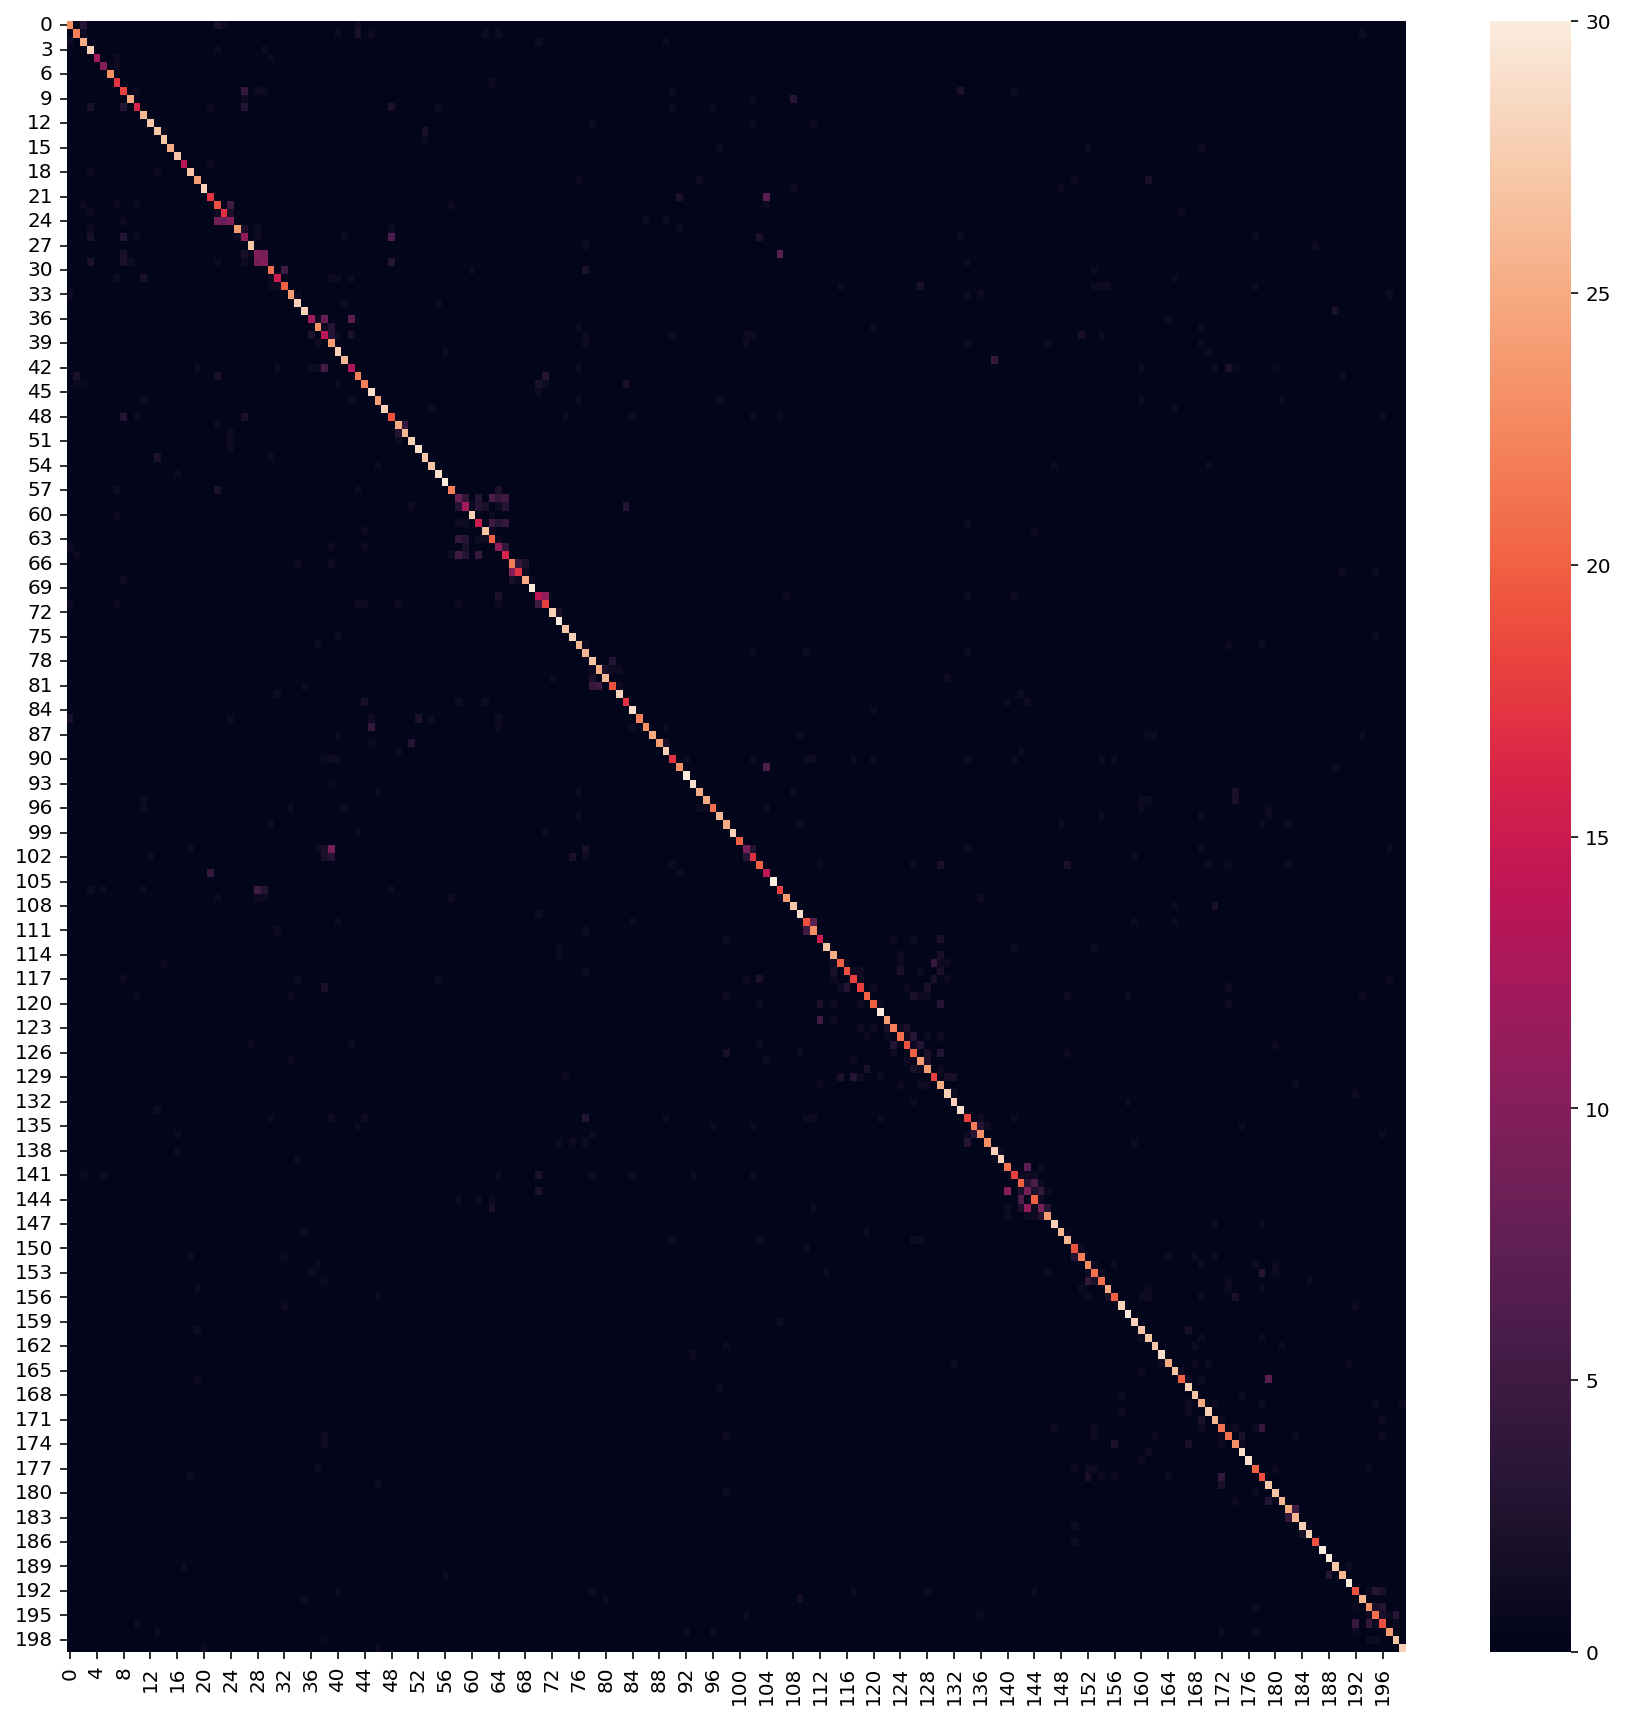

In [47]:
%%time
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model_ft.eval()

preds = []
actuals = []


for data, target in tqdm(test_loader):
    if torch.cuda.is_available(): 
        data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
        print(loss)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    labels = torch.argmax(output, 1)

    for l in labels:
      preds.append(l.item())
    for t in target:
      actuals.append(t.item())

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 64:
        for i in range(64):
            label = target.data[i]

            class_correct[label] += correct[i].item()
            class_total[label] += 1

print('Preds has ', len(preds))
print('Actual has ', len(actuals))

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


from sklearn.metrics import confusion_matrix
import seaborn as sbn
plt.figure(figsize = (15, 15))
sbn.heatmap(confusion_matrix(actuals, preds))

In [30]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Final_Model.pth")

In [31]:
from PIL import Image
from io import BytesIO
import requests

In [32]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [42]:
def predict(model, filepath, show_img=False, url=False):
    if url:
        response = requests.get(filepath)
        im = Image.open(BytesIO(response.content))
    else:
         im = Image.open(filepath)
    if show_img:
        plt.imshow(im)
    im_as_tensor = apply_test_transforms(im)
    minibatch = torch.stack([im_as_tensor])
    if torch.cuda.is_available():
        minibatch = minibatch.cuda()
    pred = model(minibatch)
    _, classnum = torch.max(pred, 1)
    print(classnum)

    return classes[classnum]

In [43]:
def formatText(string):
    string = string[4:]
    string = string.replace("-", " ")
    return string

tensor([95], device='cuda:0')


'Hooded_Oriole'

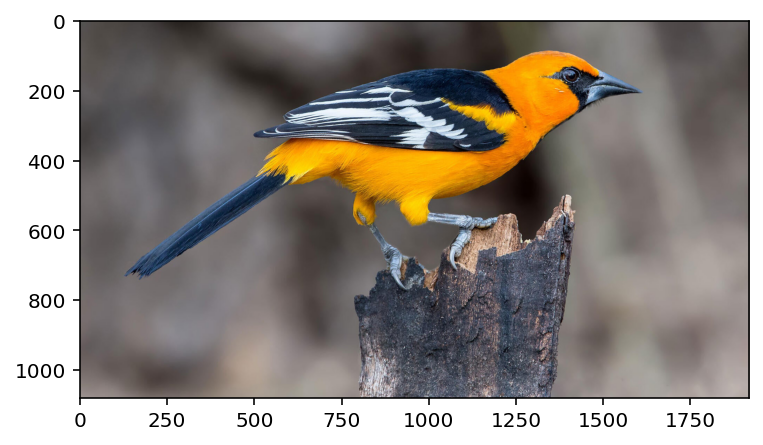

In [45]:
formatText(predict(model, "https://www.audubon.org/sites/default/files/styles/hero_cover_bird_page/public/web_h_andy-morffew_flickr-creative-common-by-2.0_altamiraoriole_flickr-3-adult.jpg?itok=ad9rnLPN", show_img=True, url=True))

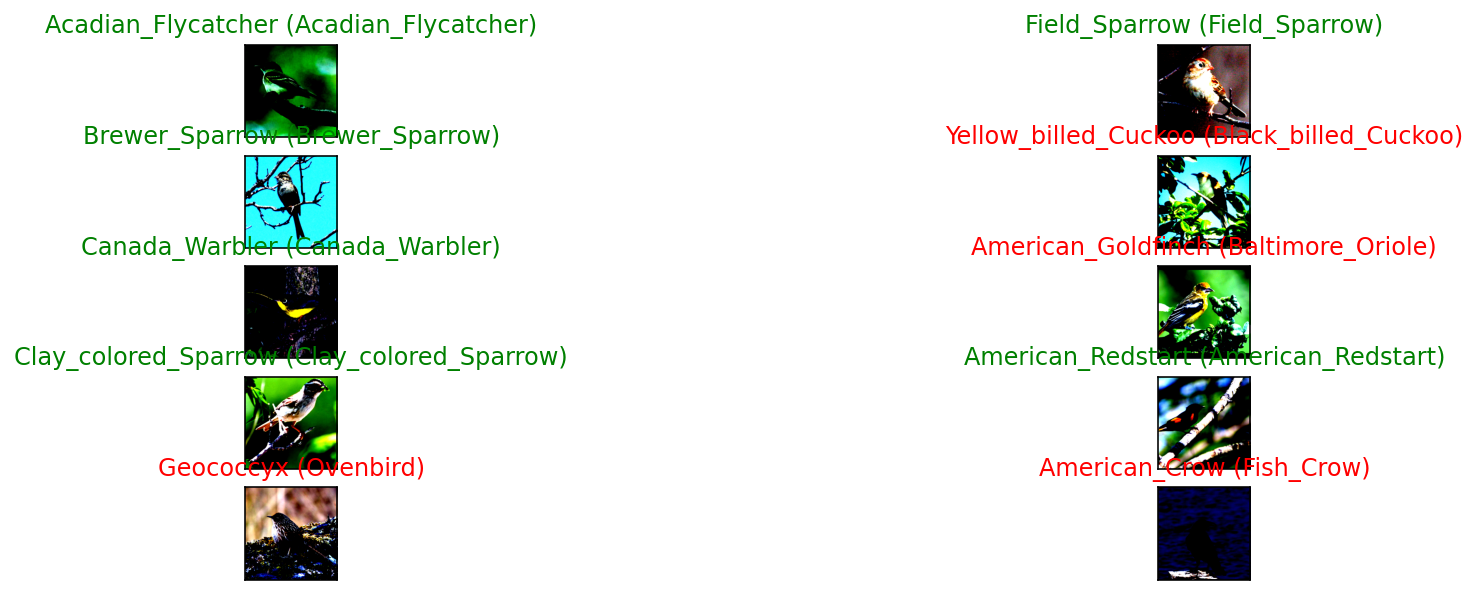

In [36]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model_ft(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(10, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(formatText(classes[preds[idx]]), formatText(classes[labels[idx]])),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))